In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-03_16-59_20180601_20191231_th70_per24_sm5.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

GC       0.25
NQ       0.25
YM       0.25
ES       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    31380.9
GC     8776.0
NQ    27250.8
YM    40522.6
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

107930.3

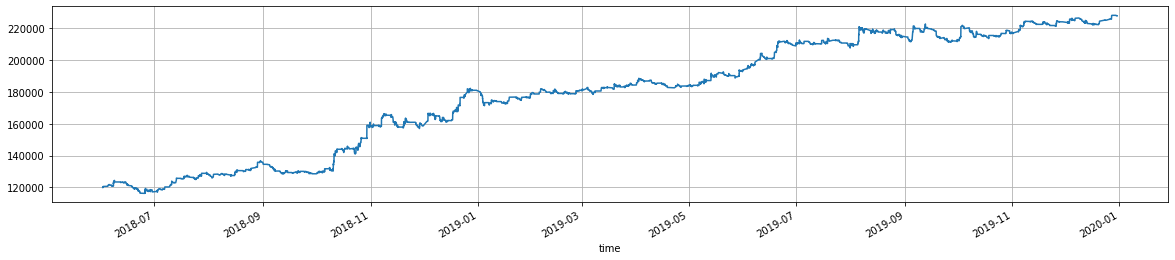

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     646
 GC    1201
 NQ    2102
 YM     644
 Name: action, dtype: int64,
 4593)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.567961
 GC    2.915049
 NQ    5.101942
 YM    1.563107
 Name: action, dtype: float64,
 11.148058252427184)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1356.60
GC    2906.42
NQ    4414.20
YM    1352.40
Name: commission, dtype: float64

In [15]:
df.commission.sum()

10029.62

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,14.63,422.37,-257.20,1.64,14.63,600.0
NQ,0.40,25.93,438.72,-247.74,1.77,26.84,1051.0
YM,0.43,125.85,764.94,-359.58,2.13,123.96,322.0
ES,0.42,97.15,914.60,-489.84,1.87,100.02,323.0
total,0.41,47.01,551.97,-298.65,1.85,50.10,2296.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.051128,0.235944,0.480270,0.753531
GC,0.051128,1.000000,0.088771,0.082225,0.389535
NQ,0.235944,0.088771,1.000000,0.228355,0.636807
YM,0.480270,0.082225,0.228355,1.000000,0.720434
total,0.753531,0.389535,0.636807,0.720434,1.000000


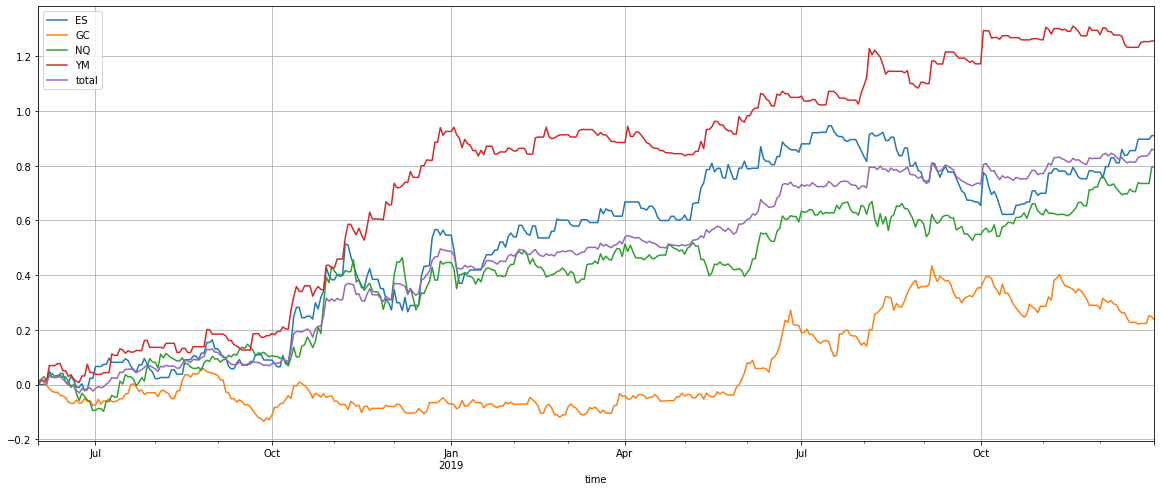

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

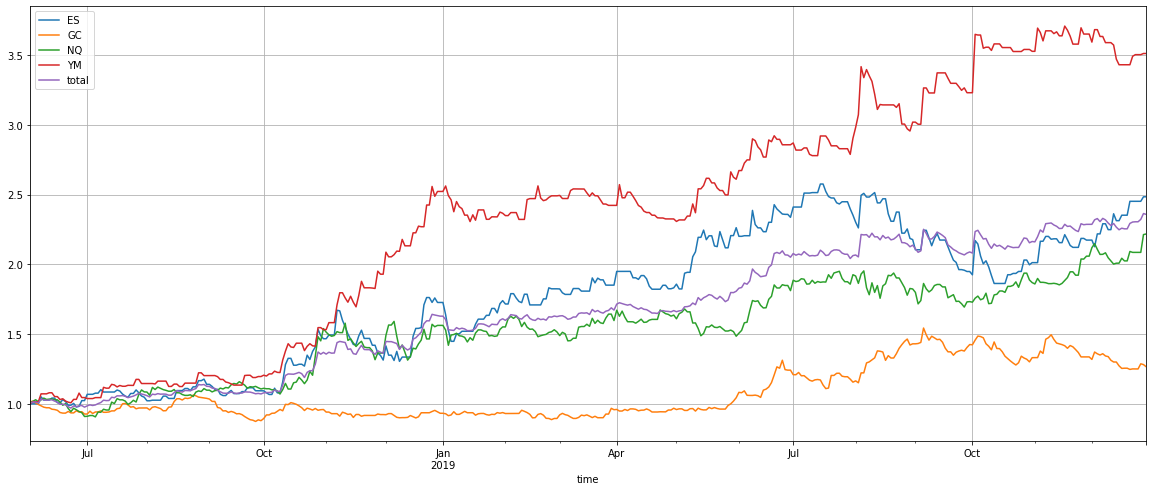

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.744718,0.155097,0.627660,1.156013,0.689987
Cumulative returns,1.484286,0.265832,1.217633,2.511507,1.358148
Annual volatility,0.412232,0.265471,0.371321,0.342821,0.225473
Sharpe ratio,1.552050,0.674003,1.496277,2.409975,2.439894
Calmar ratio,2.690891,0.807541,3.600054,8.563419,8.464529
Stability,0.835755,0.626784,0.883266,0.906165,0.952310
Max drawdown,-0.276755,-0.192060,-0.174347,-0.134994,-0.081515
Omega ratio,1.391967,1.132323,1.319826,1.778293,1.627292
Sortino ratio,2.971413,1.163508,2.516920,5.827463,5.311637
Skew,1.463586,1.156486,0.689697,2.136381,1.941158


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,2.33,-7.29,-9.07,4.50,-2.37
2018-07-31,2.37,4.69,19.40,9.63,9.13
2018-08-31,8.82,7.09,1.13,4.95,5.68
2018-09-30,-4.03,-15.39,0.80,-0.54,-4.88
2018-10-31,34.08,9.10,39.08,28.12,27.81
2018-11-30,-10.44,-3.78,-11.39,25.94,-0.50
2018-12-31,31.44,1.00,14.55,30.74,19.57
2019-01-31,0.76,0.54,-0.70,-6.19,-1.15
2019-02-28,4.87,-4.50,-2.33,5.28,0.96


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       148.0
GC        27.0
NQ       122.0
YM       251.0
total    136.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:45:00,YM,BUY,26061.00,3885.80
2018-10-11 04:24:00,ES,BUY,2767.00,3395.80
2018-12-17 17:03:00,ES,BUY,2597.00,3333.30
2018-12-21 21:59:30,ES,BUY,2421.50,3333.30
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
...,...,...,...,...
2018-11-21 08:41:00,ES,BUY,2657.75,-1154.20
2018-11-28 18:02:00,ES,BUY,2708.00,-1166.70
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.103470,0.061516,0.035793,0.112220,0.078250
2019-10-02,0.127637,0.023527,0.016300,0.129527,0.074248
2019-09-05,0.066387,0.071505,0.070387,0.086553,0.073708
2018-10-29,0.089443,-0.012989,0.101773,0.094193,0.068105
2018-12-03,0.077360,-0.000989,0.092747,0.081860,0.062744
...,...,...,...,...,...
2018-11-15,-0.026113,-0.026989,-0.020673,-0.024280,-0.024514
2019-08-26,-0.063613,0.018849,-0.017780,-0.046280,-0.027206
2018-12-10,-0.051947,-0.003656,-0.061173,-0.000780,-0.029389
